In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset
import datasets
from prettytable import PrettyTable

from tqdm import tqdm
from transformers import BertTokenizer
import torch.nn.init as init
import torch.optim as optim

import matplotlib.pyplot as plt

plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('lines', markersize=10)

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/Users/quyenlinhta/PycharmProjects/llm-iasd/llm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
dataset = load_dataset("scikit-learn/imdb", split='train')

In [4]:
def preprocessing_fn(data, tokenizer):
    tokenized_output = tokenizer(
        data["review"],
        add_special_tokens=True, 
        truncation=True,
        max_length=256,
        padding="max_length",  
        return_attention_mask=True 
    )
    return {
        "input_ids": torch.tensor(tokenized_output['input_ids']),
        "attention_mask": torch.tensor(tokenized_output['attention_mask']),
        "label": torch.tensor([0 if sentiment == "negative" else 1 for sentiment in data["sentiment"]])
    }

dataset = dataset.map(lambda x: preprocessing_fn(x, tokenizer), batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

def custom_collate_fn(batch):
    from torch.nn.utils.rnn import pad_sequence
    input_ids = pad_sequence([item['input_ids'] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence([item['attention_mask'] for item in batch], batch_first=True, padding_value=0)
    labels = torch.stack([item['label'] for item in batch])
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'label': labels}

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

In [5]:
embedding_dim = 128
epochs = 5
device = torch.device('mps')

In [6]:
class ConvolutionModel(nn.Module):
    def __init__(self, embeddings, num_filters=128):
        super(ConvolutionModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=7, padding=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.bn = nn.BatchNorm1d(num_filters * 3)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(num_filters * 3, 1)
        self.activation = nn.Sigmoid()
        self._init_weights()

    def forward(self, input_ids):
        input_ids = input_ids.to(device).long()
        x = self.embedding(input_ids)
        x1 = self.conv1(x.permute(0, 2, 1))
        x2 = self.conv2(x.permute(0, 2, 1))
        x3 = self.conv3(x.permute(0, 2, 1))
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.pool(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = torch.max(x, 2)[0]
        x = self.fc(x)
        return self.activation(x)

    def _init_weights(self):
        for conv in [self.conv1, self.conv2, self.conv3]:
            init.xavier_normal_(conv.weight)
            if conv.bias is not None:
                init.constant_(conv.bias, 0)
        init.xavier_normal_(self.fc.weight)
        init.constant_(self.fc.bias, 0)

In [7]:
def load_model(path):
    checkpoint = torch.load(path)
    return checkpoint['context_embeddings'], checkpoint['target_embeddings']

In [8]:
def train_model(model, train_loader, test_loader, device):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    acc_train, acc_val = [], []
    loss_train, loss_val = [], []

    for epoch in range(epochs):
        model.train()
        total_loss_train = 0
        correct_train = 0
        total_train = 0
        train_tqdm = tqdm(train_loader, desc=f'Epoch {epoch + 1}')

        for data in train_tqdm:
            inputs, labels = data['input_ids'].to(device), data['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            total_loss_train += loss.item() * inputs.size(0)
            predicted = outputs.round()
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            train_tqdm.set_postfix(loss=loss.item())

        average_train_loss = total_loss_train / total_train
        train_accuracy = 100 * correct_train / total_train
        acc_train.append(train_accuracy)
        loss_train.append(average_train_loss)

        model.eval()
        total_loss_val = 0
        correct_val = 0
        total_val = 0
        val_tqdm = tqdm(test_loader, desc='Validation')

        with torch.no_grad():
            for data in val_tqdm:
                inputs, labels = data['input_ids'].to(device), data['label'].to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels.float())

                total_loss_val += loss.item() * inputs.size(0)
                predicted = outputs.round()
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                val_accuracy = 100 * correct_val / total_val
                val_tqdm.set_postfix(accuracy=f'{val_accuracy:.2f}%')

        average_val_loss = total_loss_val / total_val
        val_accuracy = 100 * correct_val / total_val
        acc_val.append(val_accuracy)
        loss_val.append(average_val_loss)

        print(f'Epoch {epoch + 1}: Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
    return acc_train, acc_val, loss_train, loss_val

In [9]:
embedding = load_model('model_dim-128_radius-5_ratio-5-batch-256-epoch-5.ckpt')
context_embeddings, target_embeddings = embedding

model = ConvolutionModel(context_embeddings)
acc_train, acc_val, loss_train, loss_val = train_model(model, train_loader, test_loader, device)

Validation: 100%|██████████| 313/313 [00:04<00:00, 68.17it/s, accuracy=84.38%]


Epoch 1: Train Loss: 0.5442, Train Accuracy: 72.87%, Validation Loss: 0.3542, Validation Accuracy: 84.38%


Validation: 100%|██████████| 313/313 [00:04<00:00, 69.73it/s, accuracy=86.23%]


Epoch 2: Train Loss: 0.3824, Train Accuracy: 82.92%, Validation Loss: 0.3216, Validation Accuracy: 86.23%


Validation: 100%|██████████| 313/313 [00:02<00:00, 124.29it/s, accuracy=86.44%]


Epoch 3: Train Loss: 0.3520, Train Accuracy: 84.67%, Validation Loss: 0.3171, Validation Accuracy: 86.44%


Validation: 100%|██████████| 313/313 [00:02<00:00, 127.31it/s, accuracy=86.76%]


Epoch 4: Train Loss: 0.3182, Train Accuracy: 86.30%, Validation Loss: 0.3005, Validation Accuracy: 86.76%


Validation: 100%|██████████| 313/313 [00:02<00:00, 124.22it/s, accuracy=87.48%]

Epoch 5: Train Loss: 0.3062, Train Accuracy: 87.00%, Validation Loss: 0.2959, Validation Accuracy: 87.48%


In [10]:
table = PrettyTable()
table.field_names = ['Epoch', 'Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss']
for i in range(epochs):
    table.add_row([i + 1, f'{acc_train[i]:.2f}%', f'{acc_val[i]:.2f}%', f'{loss_train[i]:.4f}', f'{loss_val[i]:.4f}'])
print(table)

+-------+----------------+---------------------+------------+-----------------+
| Epoch | Train Accuracy | Validation Accuracy | Train Loss | Validation Loss |
+-------+----------------+---------------------+------------+-----------------+
|   1   |     72.87%     |        84.38%       |   0.5442   |      0.3542     |
|   2   |     82.92%     |        86.23%       |   0.3824   |      0.3216     |
|   3   |     84.67%     |        86.44%       |   0.3520   |      0.3171     |
|   4   |     86.30%     |        86.76%       |   0.3182   |      0.3005     |
|   5   |     87.00%     |        87.48%       |   0.3062   |      0.2959     |
+-------+----------------+---------------------+------------+-----------------+


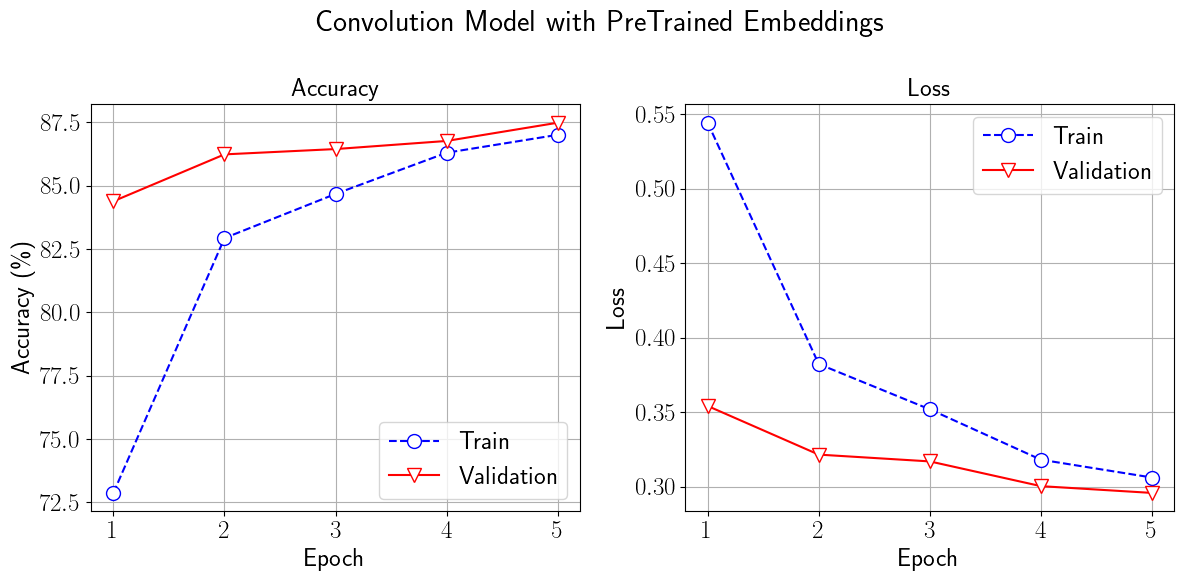

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
marker = ["o", "v"]
color = ["blue", "red"]
linestyle = ["--", "-"]
markerfacecolor = ["white", "white"]
markersize = 10
grid = True

ax[0].plot(range(1, epochs + 1), acc_train, label='Train', marker=marker[0], color=color[0], linestyle=linestyle[0], markerfacecolor=markerfacecolor[0], markersize=markersize)
ax[0].plot(range(1, epochs + 1), acc_val, label='Validation', marker=marker[1], color=color[1], linestyle=linestyle[1], markerfacecolor=markerfacecolor[1], markersize=markersize)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy (\%)')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].grid(grid)

ax[1].plot(range(1, epochs + 1), loss_train, label='Train', marker=marker[0], color=color[0], linestyle=linestyle[0], markerfacecolor=markerfacecolor[0], markersize=markersize)
ax[1].plot(range(1, epochs + 1), loss_val, label='Validation', marker=marker[1], color=color[1], linestyle=linestyle[1], markerfacecolor=markerfacecolor[1], markersize=markersize)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].grid(grid)
fig.suptitle('Convolution Model with PreTrained Embeddings')
plt.tight_layout()
plt.show()

In [12]:
def predict_sentiment(model, tokenizer, sentence, device):
    model.eval()
    tokenized_output = tokenizer(
        sentence,
        add_special_tokens=True, 
        truncation=True,
        max_length=256,
        padding="max_length",  
        return_attention_mask=True 
    )
    input_ids = torch.tensor(tokenized_output['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(tokenized_output['attention_mask']).unsqueeze(0).to(device)
    output = model(input_ids).item()
    return 'Positive' if output >= 0.5 else 'Negative'

In [13]:
sentence = "This movie was really good and I enjoyed it a lot"
predict_sentiment(model, tokenizer, sentence, device)

'Positive'

In [14]:
class ConvolutionModelNotPretrained(nn.Module):
    def __init__(self, num_filters=128):
        super(ConvolutionModelNotPretrained, self).__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=7, padding=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.bn = nn.BatchNorm1d(num_filters * 3)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(num_filters * 3, 1)
        self.activation = nn.Sigmoid()
        self._init_weights()

    def forward(self, input_ids, attention_mask=None):
        input_ids = input_ids.to(device).long()
        x = self.embedding(input_ids)
        x1 = self.conv1(x.permute(0, 2, 1))
        x2 = self.conv2(x.permute(0, 2, 1))
        x3 = self.conv3(x.permute(0, 2, 1))
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.pool(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = torch.max(x, 2)[0]
        x = self.fc(x)
        return self.activation(x)

    def _init_weights(self):
        for conv in [self.conv1, self.conv2, self.conv3]:
            init.xavier_normal_(conv.weight)
            if conv.bias is not None:
                init.constant_(conv.bias, 0)
        init.xavier_normal_(self.fc.weight)
        init.constant_(self.fc.bias, 0)

In [15]:
model_not_pretrained = ConvolutionModelNotPretrained()
acc_train, acc_val, loss_train, loss_val = train_model(model_not_pretrained, train_loader, test_loader, device)

Validation: 100%|██████████| 313/313 [00:02<00:00, 125.29it/s, accuracy=81.29%]


Epoch 1: Train Loss: 0.5524, Train Accuracy: 72.35%, Validation Loss: 0.4091, Validation Accuracy: 81.29%


Validation: 100%|██████████| 313/313 [00:02<00:00, 112.85it/s, accuracy=82.38%]


Epoch 2: Train Loss: 0.4196, Train Accuracy: 80.43%, Validation Loss: 0.3855, Validation Accuracy: 82.38%


Validation: 100%|██████████| 313/313 [00:02<00:00, 128.96it/s, accuracy=83.91%]


Epoch 3: Train Loss: 0.3866, Train Accuracy: 82.57%, Validation Loss: 0.3586, Validation Accuracy: 83.91%


Validation: 100%|██████████| 313/313 [00:04<00:00, 73.72it/s, accuracy=85.01%]


Epoch 4: Train Loss: 0.3535, Train Accuracy: 84.08%, Validation Loss: 0.3362, Validation Accuracy: 85.01%


Validation: 100%|██████████| 313/313 [00:04<00:00, 72.98it/s, accuracy=86.67%]

Epoch 5: Train Loss: 0.3222, Train Accuracy: 85.99%, Validation Loss: 0.3094, Validation Accuracy: 86.67%


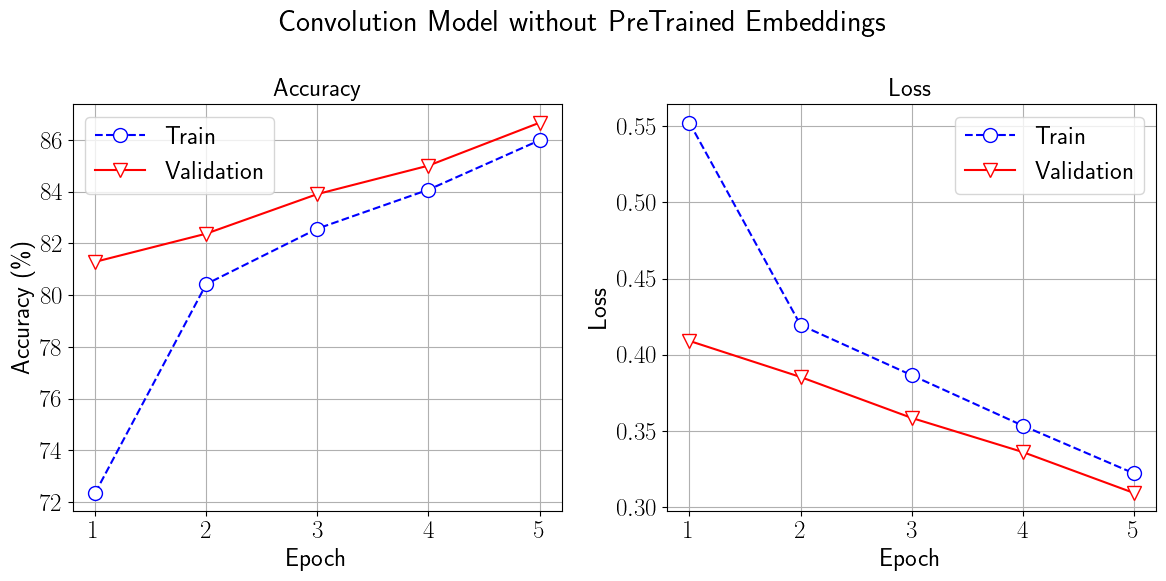

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
marker = ["o", "v"]
color = ["blue", "red"]
linestyle = ["--", "-"]
markerfacecolor = ["white", "white"]
markersize = 10
grid = True

ax[0].plot(range(1, epochs + 1), acc_train, label='Train', marker=marker[0], color=color[0], linestyle=linestyle[0], markerfacecolor=markerfacecolor[0], markersize=markersize)
ax[0].plot(range(1, epochs + 1), acc_val, label='Validation', marker=marker[1], color=color[1], linestyle=linestyle[1], markerfacecolor=markerfacecolor[1], markersize=markersize)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy (\%)')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].grid(grid)

ax[1].plot(range(1, epochs + 1), loss_train, label='Train', marker=marker[0], color=color[0], linestyle=linestyle[0], markerfacecolor=markerfacecolor[0], markersize=markersize)
ax[1].plot(range(1, epochs + 1), loss_val, label='Validation', marker=marker[1], color=color[1], linestyle=linestyle[1], markerfacecolor=markerfacecolor[1], markersize=markersize)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].grid(grid)
fig.suptitle('Convolution Model without PreTrained Embeddings')
plt.tight_layout()
plt.show()